In [1]:
import meep as mp
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import Video
from scipy.constants import pi, c
from scipy.signal import hilbert, find_peaks
from scipy.interpolate import interp1d

In [2]:
plt.rcParams['figure.figsize'] = [10,5]

In [3]:
#Define conversion functions/factors to get to/from meep units and kms
#Length factor to transform lengths in kms
l_unit = 1e-6 #1 um
t_unit = l_unit/c #time unit is length/c

#multiplicative constants to convert frequencies from meep to kms hertz
freq_unit = c/l_unit

print("1 meep Length unit is", l_unit*1e+6, "um")
print("1 meep Time unit is", t_unit*1e+15, "fs")
print("1 meep Frequency unit is", freq_unit*1e-12, "THz")

1 meep Length unit is 1.0 um
1 meep Time unit is 3.3356409519815204 fs
1 meep Frequency unit is 299.792458 THz


# Resolution

In [4]:
#courant factor
S = 0.5

#resolution is number of pixels per meep unit
resolution = 20

#resolutions in meep units
space_res = 1/resolution
time_res = space_res*S

print("Pixel per unit: ", resolution)

print("Space resolution [meep]: ", space_res)
print("Time resolution [meep]: ", time_res)

print("Space resolution [um]: ", space_res*l_unit*1e+6)
print("Time resolution [fs]: ", time_res*t_unit*1e+15)

Pixel per unit:  20
Space resolution [meep]:  0.05
Time resolution [meep]:  0.025
Space resolution [um]:  0.049999999999999996
Time resolution [fs]:  0.08339102379953803


# Geometry Definition
Cell

In [5]:
#define cell size and resolution
#Cell size is in meep units
#center is in (0,0), ranges in x=(-sx/2,sx/2), y=(-sy/2,sy/2)
sx = 24
sy = 20

cell = mp.Vector3(sx, sy)

#boundary conditions thickness
pml_thickness = 1.0

#automatic positioning of boundaries
x_bound_up = sx/2 - pml_thickness
x_bound_low = -sx/2 + pml_thickness

y_bound_up = sy/2 - pml_thickness
y_bound_low = -sy/2 + pml_thickness

In [6]:
#materials refractive indexes
n_bgnd = 1
n_wvg = 1.7
n_ring = n_wvg

#Separating distance
d = 0.1

#Width properties
wvg_width = 1

ring_r = 4
ring_w = wvg_width

#Position properties
wvg_x = 0
wvg_y = -(wvg_width + d + ring_w*2 + ring_r*2)/2 + wvg_width/2

ring_x = 0
ring_y = wvg_y + wvg_width/2 + d + ring_w + ring_r


Source

In [7]:
#Soure parameters
source_x = x_bound_low + 1
source_y = wvg_y

source_width = wvg_width

#note: df is not really the frequency sigma
f_central = 0.4
df = 0.05

print("#Source pulse frequency: fcent= ", f_central*freq_unit*1e-12, " THz, df= ",df*freq_unit*1e-12, " THz" )
print("#Source vacuum wavelength: lambda = ",  c/(f_central*freq_unit)*1e+6, "um, dlambda = ",c/(df*freq_unit)*1e+6,"um")
print("#Source wvg wavelength: lambda = ",  (c/n_wvg)/(f_central*freq_unit)*1e+6, "um")
print("#Source ring wavelength: lambda = ",  (c/n_ring)/(f_central*freq_unit)*1e+6, "um")

#Source pulse frequency: fcent=  119.9169832  THz, df=  14.9896229  THz
#Source vacuum wavelength: lambda =  2.5 um, dlambda =  20.0 um
#Source wvg wavelength: lambda =  1.4705882352941178 um
#Source ring wavelength: lambda =  1.4705882352941178 um


Monitors

In [8]:

#Monitor parameters
#input
mon_1_x = source_x + 1
mon_1_y = wvg_y
mon_1_width = wvg_width

#output
mon_2_x = x_bound_up - 1
mon_2_y = wvg_y
mon_2_width = wvg_width

#number of sampling points in frequency for fourier transform of fields accumulated
N_freq = 300

#central frequency
f_mon_central = f_central
#width of sampled frequency band
df_mon = df



#Point for simulation termination condition
check_pt = mp.Vector3(mon_2_x - 0.1, mon_2_y)


# Normalization Run
No DBR

-----------
Initializing structure...
time for choose_chunkdivision = 0.000263929 s
Working in 2D dimensions.
Computational cell is 24 x 20 x 0 with resolution 20
     block, center = (0,-5.05,0)
          size (1e+20,1,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.89,2.89,2.89)
     cylinder, center = (0,0.55,0)
          radius 5, height 1e+20, axis (0, 0, 1)
          dielectric constant epsilon diagonal = (2.89,2.89,2.89)
     cylinder, center = (0,0.55,0)
          radius 4, height 1e+20, axis (0, 0, 1)
          dielectric constant epsilon diagonal = (1,1,1)
time for set_epsilon = 0.454382 s
-----------
on time step 1926 (time=48.15), 0.00207737 s/step
field decay(t = 50.025000000000006): 4.876326898319912e-05 / 4.876326898319912e-05 = 1.0
field decay(t = 100.05000000000001): 0.06557339165280754 / 0.06557339165280754 = 1.0
on time step 4076 (time=101.9), 0.0018612 s/step
field decay(t = 150.07500000000002): 0.01551193673608016

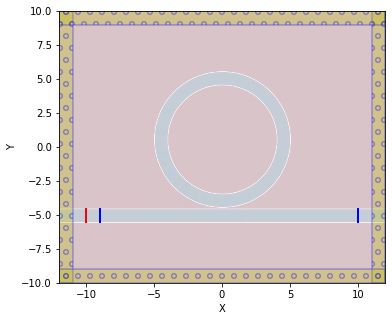

In [9]:
#Geometry objects
waveguide = mp.Block(mp.Vector3(mp.inf, wvg_width, mp.inf),
                    center = mp.Vector3(wvg_x, wvg_y),
                    material = mp.Medium(index=n_wvg))
ext_ring = mp.Cylinder(radius=ring_r+ring_w,
                    center=mp.Vector3(ring_x, ring_y),
                    material = mp.Medium(index=n_ring))
int_ring = mp.Cylinder(radius=ring_r,
                    center=mp.Vector3(ring_x, ring_y))

geometry = [waveguide,
            ext_ring,
            int_ring]

#define sources
#gaussian pulse with f_central and df
sources = [mp.Source(mp.GaussianSource(frequency=f_central, fwidth=df*3),
                     component=mp.Ez,
                     center=mp.Vector3(source_x, source_y),
                     size=mp.Vector3(0, source_width))]

#define boundary conditions
pml_layers = [mp.PML(pml_thickness)]

#Instance simulation with chosen parameters
sim = mp.Simulation(cell_size=cell,
                    boundary_layers=pml_layers,
                    sources=sources,
                    geometry=geometry,
                    resolution=resolution)

# Flux Monitor 1
incident_fr = mp.FluxRegion(center=mp.Vector3(mon_1_x, mon_1_y), size=mp.Vector3(0, mon_1_width, 0))
incident = sim.add_flux(f_mon_central, df_mon, N_freq, incident_fr)

# Flux Monitor 2
tran_fr = mp.FluxRegion(center=mp.Vector3(mon_2_x, mon_2_y), size=mp.Vector3(0,mon_2_width,0))
tran = sim.add_flux(f_mon_central, df_mon, N_freq, tran_fr)

animate = mp.Animate2D(sim,
                       fields=mp.Ez,
                       normalize=True,
                       realtime=False,
                       eps_parameters={'alpha':1, 'cmap':'RdBu', 'interpolation':'spline36'},
                       field_parameters={'alpha':0.8, 'cmap':'RdBu', 'interpolation':'spline36'},
                       boundary_parameters={'hatch':'o', 'linewidth':1.5, 'facecolor':'y', 'edgecolor':'b', 'alpha':0.3})

#Simulate
mp.verbosity(1)
sim.run(mp.at_every(1, animate), until_after_sources = mp.stop_when_fields_decayed(50, mp.Ez, check_pt, 1e-3))

animate.to_mp4(10, "Ez_norm.mp4")

In [10]:
Video("Ez_norm.mp4")

In [11]:

#Get Fourier-transformed fields of incident pulse
norm_incident_data = sim.get_flux_data(incident)

#Get fluxes from fourier transformed fields transmitted
norm_tran_flux = mp.get_fluxes(tran)

#Get fluxes from fourier transformed incident fields
norm_inc_flux = mp.get_fluxes(incident)

flux_freqs = mp.get_flux_freqs(tran)

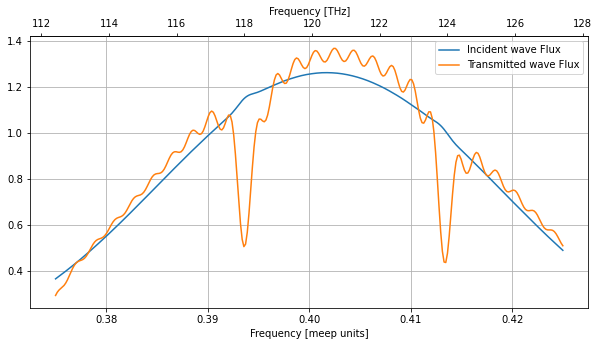

In [12]:
plt.plot(flux_freqs, norm_inc_flux, label="Incident wave Flux")
plt.plot(flux_freqs, norm_tran_flux, label="Transmitted wave Flux")

plt.xlabel("Frequency [meep units]")

ax = plt.gca()

def MU2THz(x):
    return x *freq_unit*1e-12


def THz2MU(x):
    return x /(freq_unit*1e-12)

secax = ax.secondary_xaxis('top', functions=(MU2THz, THz2MU))
secax.set_xlabel('Frequency [THz]')

plt.legend()
plt.grid()

In [13]:
sim.reset_meep()

# Actual Run

In [14]:
#define geometry

#Background material
geometry = [mp.Block(mp.Vector3(mp.inf, mp.inf, mp.inf),
                     center=mp.Vector3(0,0),
                     material=mp.Medium(index=n_1))]

#Layers Material
for ii in range(N_layers):
    geometry.append(mp.Block(mp.Vector3(width_2, mp.inf, mp.inf),
                     center=mp.Vector3(ii*(width_1+width_2) -bragg_width/2 + width_1 + width_2/2, 0),
                     material=mp.Medium(index=n_2)))
    
#define sources
sources = [mp.Source(mp.GaussianSource(frequency=f_central, fwidth=df*2),
                     component=mp.Ez,
                     center=mp.Vector3(source_x, 0),
                     size=mp.Vector3(0, source_width))]

#define boundary conditions
pml_layers = [mp.PML(pml_thickness)]


#Instance simulation with chosen parameters
sim = mp.Simulation(cell_size=cell,
                    boundary_layers=pml_layers,
                    geometry=geometry,
                    sources=sources,
                    resolution=resolution)


NameError: name 'n_1' is not defined

In [ ]:
##Flux Monitors Definition

#First instantiate a flux region object by telling its geometric parameters
#Then call add_flux on simulation object, passing the fluxregion as parameter. Returns flux object

#This tells meep to perform the following:
#For each of the chosen frequencies, and for each of the fields components,
#accumulate the discrete fourier transform until the end of the simulation

#Desired frequencies are in (fcen-df/2, fcen+df/2)

# Flux Monitor 1
refl_fr = mp.FluxRegion(center=mp.Vector3(mon_1_x, 0), size=mp.Vector3(0,mon_1_width,0))
refl = sim.add_flux(f_mon_central, df_mon, N_freq, refl_fr)

# Flux Monitor 2
tran_fr = mp.FluxRegion(center=mp.Vector3(mon_2_x, 0), size=mp.Vector3(0,mon_2_h,0))
tran = sim.add_flux(f_mon_central, df_mon, N_freq, tran_fr)

In [ ]:
#load normalization data
sim.load_minus_flux_data(refl, norm_incident_data)

In [ ]:
#Runs simulation and save animation of Ez
animate = mp.Animate2D(sim,
                       fields=mp.Ez,
                       normalize=True,
                       realtime=False,
                       eps_parameters={'alpha':1, 'cmap':'RdBu', 'interpolation':'spline36'},
                       field_parameters={'alpha':0.8, 'cmap':'RdBu', 'interpolation':'spline36'},
                       boundary_parameters={'hatch':'o', 'linewidth':1.5, 'facecolor':'y', 'edgecolor':'b', 'alpha':0.3})


sim.run(mp.at_every(1, animate), until_after_sources = mp.stop_when_fields_decayed(50, mp.Ez, check_pt, 5e-3))
        #until_after_sources=mp.stop_when_fields_decayed(50,mp.Ez,pt,1e-3))

animate.to_mp4(10, "Ez_DBR.mp4")

In [ ]:
Video("Ez_DBR.mp4")

In [ ]:
# Get Final Fluxes
bragg_tran_flux = np.array(mp.get_fluxes(tran))
bragg_refl_flux = np.array(mp.get_fluxes(refl))*(-1)

flux_freqs = np.array(mp.get_flux_freqs(refl))

In [ ]:
plt.plot(flux_freqs, bragg_tran_flux, label="Transmitted wave Flux")
plt.plot(flux_freqs, norm_tran_flux, label="No structure Transmitted wave Flux")

plt.plot(flux_freqs, bragg_refl_flux, label="Reflected wave Flux")

plt.plot(flux_freqs, norm_inc_flux, label="Incident wave Flux")

ax = plt.gca()

def MU2THz(x):
    return x *freq_unit*1e-12


def THz2MU(x):
    return x /(freq_unit*1e-12)

secax = ax.secondary_xaxis('top', functions=(MU2THz, THz2MU))
secax.set_xlabel('Frequency [THz]')

plt.legend()
plt.grid()

In [ ]:
# Transmittance and reflectance

wvlength = 1/flux_freqs

T = bragg_tran_flux/norm_tran_flux
R = bragg_refl_flux/norm_tran_flux
Losses = 1-T-R

plt.plot(flux_freqs, T, label="Transmittance")
plt.plot(flux_freqs, R, label="Reflectance")
plt.plot(flux_freqs, Losses, label="DBR Losses")

ax = plt.gca()

def MU2THz(x):
    return x *freq_unit*1e-12


def THz2MU(x):
    return x /(freq_unit*1e-12)

secax = ax.secondary_xaxis('top', functions=(MU2THz, THz2MU))
secax.set_xlabel('Frequency [THz]')

plt.legend()
plt.grid()

Dubbi: formalmente come faccio a costruire una sorgente che eccita solo alcuni modi della struttura?
Come faccio a capire quali modi eccita una sorgente arbitraria?
Come misuro aitomaticamente il bandgap?

# Notes
- Dn = +1.4, n_1 = 1.45, wm = 0.225, wmin = 0.18, wmax =0.275 Dw=0.095
- Dn = 1, n_1 = 1.45, wm = 0.255, wmin = 0.215, wmax =0.287 Dw=0.072

# Bandgap Identification

In [ ]:
# Transmittance and reflectance

wvlength = 1/flux_freqs

T = bragg_tran_flux/norm_tran_flux
R = bragg_refl_flux/norm_tran_flux
Losses = 1-T-R

diff_T = np.diff(T)
diff_R = np.diff(R)
diff_Losses = np.diff(Losses)

In [ ]:
print(len(diff_T))
print(len(flux_freqs[:-1]))

plt.plot(flux_freqs[:-1], diff_T, label="Transmittance")
plt.plot(flux_freqs[:-1], diff_R, label="Reflectance")
plt.plot(flux_freqs[:-1], diff_Losses, label="DBR Losses")


ax = plt.gca()

def MU2THz(x):
    return x *freq_unit*1e-12


def THz2MU(x):
    return x /(freq_unit*1e-12)

secax = ax.secondary_xaxis('top', functions=(MU2THz, THz2MU))
secax.set_xlabel('Frequency [THz]')



plt.legend()
plt.grid()

In [ ]:
#get maxima of drivative to get lower and upper bound of bandgap
diff_R_abs =np.abs(diff_R)
max_val = np.amax(diff_R)
max_index = np.argmax(diff_R)

peaks, _ = find_peaks(diff_R_abs, height=0.01)
print(flux_freqs[peaks])
print(flux_freqs[peaks][peaks>=max_index])

ind = np.argpartition(diff_R[peaks][peaks>=max_index], -2)[-2:]
bandgap_bounds = flux_freqs[peaks][peaks>=max_index][ind][::-1]

print(bandgap_bounds)

In [ ]:
bandgap_mean = np.mean(bandgap_bounds)
bandgap_delta = bandgap_bounds[1]-bandgap_bounds[0]
bandgap_ratio = bandgap_delta/bandgap_mean

print("Mean freqeuency: ",bandgap_mean)
print("Delta freqeuency: ",bandgap_delta)
print("Ratio Delta/mean: ",bandgap_ratio)

In [ ]:

print(len(diff_T))
print(len(flux_freqs[:-1]))

plt.plot(flux_freqs[:-1], diff_T, label="Transmittance")
plt.plot(flux_freqs[:-1], diff_R, label="Reflectance")
plt.plot(flux_freqs[:-1], diff_Losses, label="DBR Losses")

plt.axvline(bandgap_bounds[0], color="red", linestyle="dashed")
plt.axvline(bandgap_bounds[1], color="red", linestyle="dashed")
plt.axvline(bandgap_mean, color="red", linestyle="dashed")


ax = plt.gca()

def MU2THz(x):
    return x *freq_unit*1e-12


def THz2MU(x):
    return x /(freq_unit*1e-12)

secax = ax.secondary_xaxis('top', functions=(MU2THz, THz2MU))
secax.set_xlabel('Frequency [THz]')



plt.legend()
plt.grid()